In [4]:
%load_ext autoreload
%autoreload 2

import gc
import os
import pandas as pd
import numpy as np
import re
import math
from collections import defaultdict

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

import json
from tqdm import tqdm



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
os.chdir("T:\\laupodteam\\AIOS\\Bram\\notebooks\\code_dev\\negation-detection")

In [6]:
DCC = pd.read_csv("data/EMCDutchClinicalCorpus/all.csv", sep=";", encoding='latin1', engine='c')
to_exclude = json.load(open("data/EMCDutchClinicalCorpus/DCC_files_to_exclude.json"))
include_exclusion = ['corrupted', 'empty', 'annotation']
ignore_list = [] 
for k,v in to_exclude.items():
    if k in include_exclusion:
        for _v in v:
            ignore_list.append(_v['name'])


In [7]:
len(ignore_list)

2115

In [8]:
DCC.columns = ['name', 'text']
DCC['group'] = DCC.name.str[:2]
DCC['num_words'] = DCC.text.apply(lambda x: len(x.split()))
DCC['num_unique_words'] = DCC.text.apply(lambda x: len(set(x.split())))
DCC['num_sentences'] = DCC.text.apply(lambda x: len(x.split(".")))
DCC['num_words_per_sentence'] = DCC.num_words / DCC.num_sentences
DCC['num_unique_words_per_sentence'] = DCC.num_unique_words / DCC.num_sentences
DCC['num_words_per_unique_word'] = DCC.num_words / DCC.num_unique_words
DCC['avg_word_length'] = DCC.text.apply(lambda x: np.mean([len(w) for w in x.split()]))
DCC['unique_words_per_word'] = DCC.num_unique_words / DCC.num_words
DCC  = DCC[~DCC.name.isin(ignore_list)]

In [9]:
total_per_group = DCC.groupby('group').text.agg(text=lambda x: " ".join(x))
total_per_group['num_words'] = total_per_group.text.apply(lambda x: len(x.split()))
total_per_group['num_unique_words'] = total_per_group.text.apply(lambda x: len(set(x.split())))
total_per_group['num_sentences'] = total_per_group.text.apply(lambda x: len(x.split(".")))
total_per_group['num_words_per_sentence'] = total_per_group.num_words / total_per_group.num_sentences
total_per_group['num_unique_words_per_sentence'] = total_per_group.num_unique_words / total_per_group.num_sentences
total_per_group['num_words_per_unique_word'] = total_per_group.num_words / total_per_group.num_unique_words
total_per_group['avg_word_length'] = total_per_group.text.apply(lambda x: np.mean([len(w) for w in x.split()]))

Text(0.5, 0, 'Number of words')

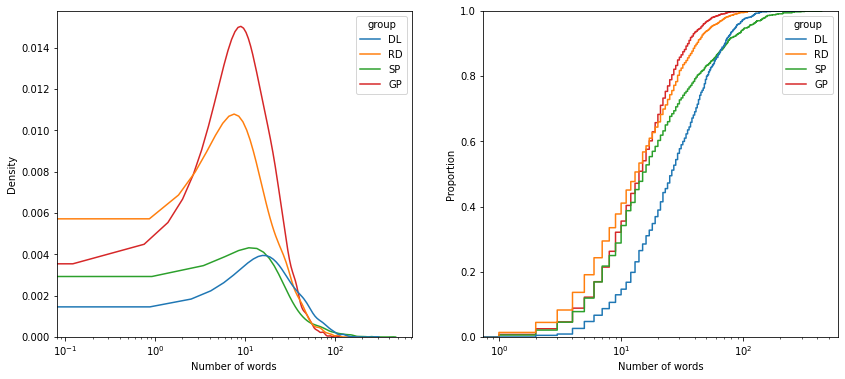

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
sns.kdeplot(data=DCC, x='num_words', hue='group', ax=ax[0])
ax[0].semilogx()
ax[0].set_xlabel('Number of words')

sns.ecdfplot(DCC, x='num_words', hue='group', ax = ax[1])
ax[1].semilogx()
ax[1].set_xlabel('Number of words')


Text(0.5, 0, 'Number of unique words')

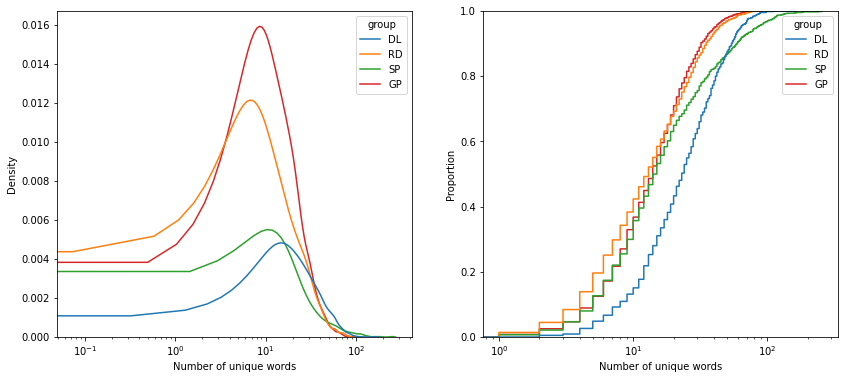

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
sns.kdeplot(data=DCC, x='num_unique_words', hue='group', ax=ax[0])
ax[0].semilogx()
ax[0].set_xlabel('Number of unique words')

sns.ecdfplot(DCC, x='num_unique_words', hue='group', ax = ax[1])
ax[1].semilogx()
ax[1].set_xlabel('Number of unique words')


Text(0.5, 0, 'Number of words per sentence')

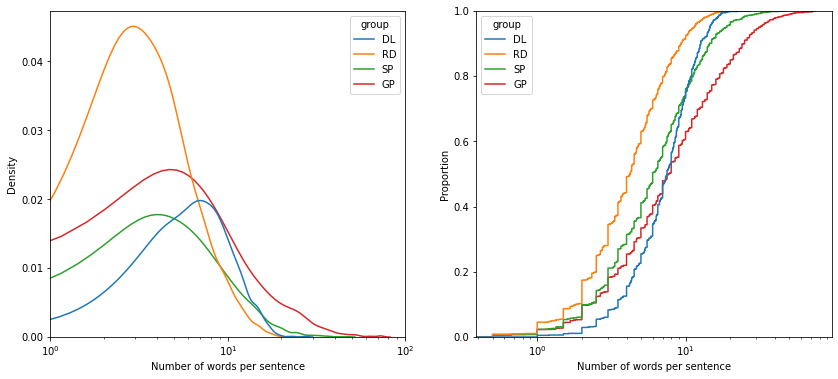

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
sns.kdeplot(data=DCC, x='num_words_per_sentence', hue='group', ax=ax[0])
ax[0].set_xlim(1,100)
ax[0].semilogx()
ax[0].set_xlabel('Number of words per sentence')

sns.ecdfplot(DCC, x='num_words_per_sentence', hue='group', ax = ax[1])
ax[1].semilogx()
ax[1].set_xlabel('Number of words per sentence')

(0.8, 1.5)

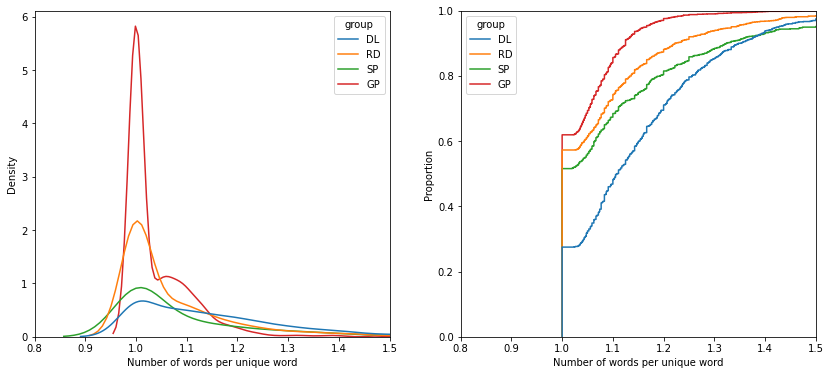

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
sns.kdeplot(data=DCC, x='num_words_per_unique_word', hue='group', ax=ax[0])
ax[0].set_xlabel('Number of words per unique word')
ax[0].set_xlim(0.8, 1.5)

sns.ecdfplot(DCC, x='num_words_per_unique_word', hue='group', ax = ax[1])
ax[1].set_xlabel('Number of words per unique word')
ax[1].set_xlim(0.8, 1.5)

(2.0, 15.0)

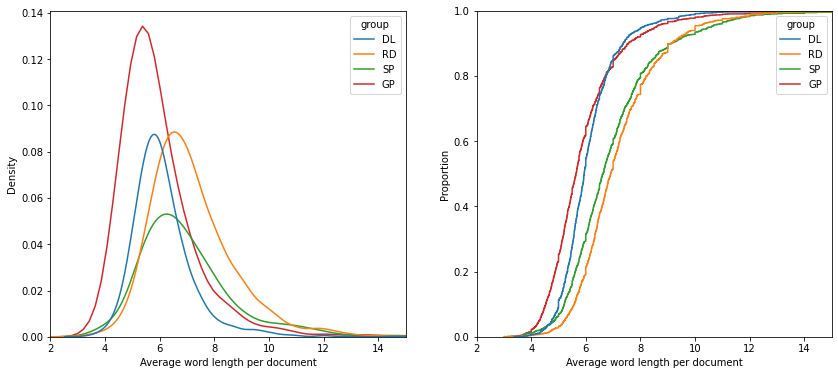

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
sns.kdeplot(data=DCC, x='avg_word_length', hue='group', ax=ax[0])
ax[0].set_xlabel('Average word length per document')
ax[0].set_xlim(2, 15)

sns.ecdfplot(DCC, x='avg_word_length', hue='group', ax = ax[1])
ax[1].set_xlabel('Average word length per document')
ax[1].set_xlim(2, 15)

In [15]:
stats = DCC[['group', 'num_words', 'num_unique_words', 'num_sentences', 'avg_word_length',
'num_words_per_sentence', 'num_unique_words_per_sentence', 'unique_words_per_word']]\
        .groupby('group').describe().round(1)

In [16]:
stats['num_words_per_sentence']

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
DL,989.0,7.9,3.7,1.0,5.0,7.5,10.0,27.3
GP,1899.0,11.1,10.4,0.5,4.0,7.7,14.5,75.0
RD,1498.0,5.0,3.2,0.5,2.6,4.2,6.5,23.5
SP,989.0,7.6,5.8,0.5,3.5,6.0,10.0,47.5


## DAPT text

In [77]:
wiki_path = "D:\LanguageModels\MEDICAL_TEXT\RAW\\nlwiki_20200901_geneeskunde_depth4.txt"
with open(wiki_path, 'r', encoding='latin1') as f:
    wiki_text = f.read()

wiki_text = re.sub('\n', ' ', wiki_text)
wiki_text = re.sub('\r', ' ', wiki_text)
wiki_text = re.sub('\t', ' ', wiki_text)
wiki_text = re.sub('[\{\}\(\)\"\'\+\,0-9\`\_\/]', ' ', wiki_text)
wiki_text = re.sub("\.{2,}", ".", wiki_text)
wiki_text = re.sub('\s{2,}', ' ', wiki_text)

sentences = wiki_text.split(".")
wiki_sentences = [s for s in sentences if len(s.split())>3]
wiki_words = [_s.lower() for s in wiki_sentences  for _s in s.split()]
wiki_words_unique = list(set(wiki_words))

print("+"*30, f"WIKI", "+"*30)
print(f"number of sentences:{len(wiki_sentences)}, \
 number of words:{len(wiki_words)}, number of unique words:{len(wiki_words_unique)}")

++++++++++++++++++++++++++++++ WIKI ++++++++++++++++++++++++++++++
number of sentences:285617,  number of words:4928938, number of unique words:213565


In [78]:
www_path = "T:\laupodteam\AIOS\Bram\language_modeling\MEDICAL_TEXT\CLEANED\www.txt"
with open(www_path, 'r', encoding='utf-8') as f:
    www_text = f.read()

www_text = re.sub('\n', ' ', www_text)
www_text = re.sub('\r', ' ', www_text)
www_text = re.sub('\t', ' ', www_text)
www_text = re.sub('[\{\}\(\)\"\'\+\,0-9\`\_\/]', ' ', www_text)
www_text = re.sub("\.{2,}", ".", www_text)
www_text = re.sub('\s{2,}', ' ', www_text)

sentences = www_text.split(".")
www_sentences = [s for s in sentences if len(s.split())>3]
www_words = [_s.lower() for s in www_sentences  for _s in s.split()]
www_words_unique = list(set(www_words))

print("+"*30, f"HNW, RD and NHG", "+"*30)
print(f"number of sentences:{len(www_sentences)}, \
 number of words:{len(www_words)}, number of unique words:{len(www_words_unique)}")

++++++++++++++++++++++++++++++ HNW, RD and NHG ++++++++++++++++++++++++++++++
number of sentences:4680419,  number of words:90997114, number of unique words:822494


In [79]:
path = "D:/Dropbox/Dropbox/UPOD_Argonauts/CVD_texts/NHG\henw_all.txt"
with open(path, 'r', encoding='utf-8') as f:
    text = f.read()
text = re.sub('\n', ' ', text)
text = re.sub('\r', ' ', text)
text = re.sub('\t', ' ', text)
text = re.sub('[\{\}\(\)\"\'\+\,0-9\`\_\/]', ' ', text)
text = re.sub("\.{2,}", ".", text)
text = re.sub('\s{2,}', ' ', text)

sentences = text.split(".")
sentences = [s for s in sentences if len(s.split())>3]
words = [_s.lower() for s in sentences  for _s in s.split()]
words_unique = list(set(words))

print("+"*30, f"HNW", "+"*30)
print(f"number of sentences:{len(sentences)}, \
 number of words:{len(words)}, number of unique words:{len(words_unique)}")

++++++++++++++++++++++++++++++ HNW ++++++++++++++++++++++++++++++
number of sentences:1176662,  number of words:22839529, number of unique words:510417


In [80]:
path = "D:/Dropbox/Dropbox/UPOD_Argonauts/CVD_texts/NHG/nhg_all.txt"
with open(path, 'r', encoding='utf-8') as f:
    text = f.read()
text = re.sub('\n', ' ', text)
text = re.sub('\r', ' ', text)
text = re.sub('\t', ' ', text)
text = re.sub('[\{\}\(\)\"\'\+\,0-9\`\_\/]', ' ', text)
text = re.sub("\.{2,}", ".", text)
text = re.sub('\s{2,}', ' ', text)

sentences = text.split(".")
sentences = [s for s in sentences if len(s.split())>3]
words = [_s.lower() for s in sentences  for _s in s.split()]
words_unique = list(set(words))

print("+"*30, f"NHG", "+"*30)
print(f"number of sentences:{len(sentences)}, \
 number of words:{len(words)}, number of unique words:{len(words_unique)}")

++++++++++++++++++++++++++++++ NHG ++++++++++++++++++++++++++++++
number of sentences:921336,  number of words:17052394, number of unique words:257030


In [81]:
path = "D:/Dropbox/Dropbox/UPOD_Argonauts/CVD_texts/NHG/rd_richtlijn.txt"
with open(path, 'r', encoding='utf-8') as f:
    text = f.read()
text = re.sub('\n', ' ', text)
text = re.sub('\r', ' ', text)
text = re.sub('\t', ' ', text)
text = re.sub('[\{\}\(\)\"\'\+\,0-9\`\_\/]', ' ', text)
text = re.sub("\.{2,}", ".", text)
text = re.sub('\s{2,}', ' ', text)

sentences = text.split(".")
sentences = [s for s in sentences if len(s.split())>3]
words = [_s.lower() for s in sentences  for _s in s.split()]
words_unique = list(set(words))

print("+"*30, f"FMS", "+"*30)
print(f"number of sentences:{len(sentences)}, \
 number of words:{len(words)}, number of unique words:{len(words_unique)}")

++++++++++++++++++++++++++++++ FMS ++++++++++++++++++++++++++++++
number of sentences:2188601,  number of words:41254869, number of unique words:325357
